<img src="img/identidade_visual.png">

# Sistema de Informações de Mortalidade - SIM

Neste notebook, iremos demonstrar como acessar os dados do SIM indexados pela Plataforma de Ciência de Dados aplicada à Saúde (PCDaS) através do R.

Os dados do SIM estão disponíveis em um índice do ElasticSearch (ES), que contém todos os registros individuais das declarações de óbito.

## Pacotes necessários

O acesso ao índice no ES é realizado através do pacote [`elastic`](https://cran.r-project.org/web/packages/elastic/elastic.pdf).

In [1]:
library(elastic)

Vamos também utilizar outras bibliotecas do R para facilitar a manipulação dos dados obtidos.

In [2]:
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:elastic’:

    count, explain

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Acesso ao ElasticSearch

O primeiro passo é informar ao R os parâmetros de conexão com o índice no ES. Para isso, vamos usar a função `connect` da blilioteca `elastic`.

Nos parâmetros `es_user` e `es_pwd`, informe o mesmo usuário e senha que você usar para acessar a plataforma.

Importante lembrar que esta conexão irá funcionar apenas através de notebooks do `Jupyter` rodando dentro da plataforma.

In [7]:
elastic::connect(
  es_host = "146.134.240.111",
  es_port = 9200,
  es_transport_schema  = "http",
  es_user = "aluno.treinamento",
  es_pwd = "aluno123456"
)

transport:  http 
host:       146.134.240.111 
port:       9200 
path:       NULL 
username:   aluno.treinamento 
password:   <secret> 
errors:     simple 
headers (names):  NULL 

Podemos testar a conexão pedindo algumas informações básicas sobre o ElasticSearch.

In [8]:
elastic::info()

$name
[1] "elastic1"

$cluster_name
[1] "elastic.fiocruz.lncc.br"

$cluster_uuid
[1] "RCB_nTLkTeGEKgF7osqmDw"

$version
$version$number
[1] "6.3.0"

$version$build_flavor
[1] "default"

$version$build_type
[1] "deb"

$version$build_hash
[1] "424e937"

$version$build_date
[1] "2018-06-11T23:38:03.357887Z"

$version$build_snapshot
[1] FALSE

$version$lucene_version
[1] "7.3.1"

$version$minimum_wire_compatibility_version
[1] "5.6.0"

$version$minimum_index_compatibility_version
[1] "5.0.0"


$tagline
[1] "You Know, for Search"

Podemos ver acima, por exemplo, que a versão do `ElasticSearch` utilizada atualmente é a 6.3.0.

## Primeiras informações

Com os comandos abaixo iremos obter algumas informações básicas do índice do SIM.

O comando `count` irá dizer quantos registros existem no banco do SIM. No jargão do ElasticSearch, podemos dizer: "quantos documentos existem no índice".

In [9]:
elastic::count("datasus-sim-dss")

[1] 22366860

O comando `mapping_get` retorna o mapeamento das variáveis, ou seja, quais variáveis existem no índice e seus tipos. Lembrando que as variáveis em letras maiúsculas são originais das declarações de óbito disponibilizadas pelo [DATASUS](http://www2.datasus.gov.br/DATASUS/index.php?area=060701) e as variáveis em letras minúsculas foram geradas pela equipe PCDaS. Não deixe de conferir o [dicionário de dados](https://bigdata-metadados.icict.fiocruz.br/dataset/sistema-de-informacoes-de-mortalidade-sim) do SIM antes de trabalhar com esses dados.

In [10]:
mapping <- elastic::mapping_get(index = "datasus-sim-dss")

## Qual é a cara dos dados?

Podemos ver alguns documentos (registros) do índice (banco do SIM) com o comando `Search`. O parâmetro `asdf` solicita que os resultados tenham o formato de tabela.

Observe abaixo que estamos acessando uma área específica do resultado retornado pela função, chamada `hits`. Os `hits` são os documentos que atendem a uma busca realizada. Como não especificamos um critério de busca, a função apresenta os primeiros 10 documentos do índice. Isso já é o bastante para termos uma ideia da cara dos dados.

Alterando a função podemos requisitar até os 10.000 primeiros resultados. Vamos ver mais a frente que dificilmente iremos precisar mais do que isso, pois iremos trabalhar com agregações.

In [11]:
elastic::Search("datasus-sim-dss", asdf = TRUE)$hits$hits

_index,_type,_id,_score,_source.OBITOPUERP,_source.DIFDATA,_source.ESCMAE,_source.VERSAOSIST,_source.QTDFILMORT,_source.res_MUNNOME,⋯,_source.def_loc_ocor,_source.GESTACAO,_source.def_escol,_source.ocor_ALTITUDE,_source.ocor_CSAUDCOD,_source.def_circ_obito,_source.def_est_civil,_source.idade_obito_horas,_source.ASSISTMED,_source.NECROPSIA
datasus-sim-dss,sim-type,Sge3D2cBKV4x6o3cuQAb,1,NA,NA,9,NA,NA,Bauru,⋯,Hospital,9,Ignorado,526,35900,Ignorado,Viúvo,NA,1,2
datasus-sim-dss,sim-type,Twe3D2cBKV4x6o3cuQAb,1,NA,NA,9,NA,NA,Agudos,⋯,Hospital,9,Ignorado,526,35900,Ignorado,Casado,NA,1,NA
datasus-sim-dss,sim-type,UQe3D2cBKV4x6o3cuQAb,1,NA,NA,9,NA,NA,Bauru,⋯,Via Pública,9,Ignorado,526,35900,Homicídio,Solteiro,NA,2,1
datasus-sim-dss,sim-type,Vge3D2cBKV4x6o3cuQAb,1,NA,NA,9,NA,NA,São Paulo,⋯,Hospital,9,Ignorado,760,35900,Ignorado,Solteiro,NA,1,2
datasus-sim-dss,sim-type,Xge3D2cBKV4x6o3cuQAb,1,NA,NA,9,NA,NA,São Paulo,⋯,Hospital,9,Ignorado,760,35900,Ignorado,Viúvo,NA,1,NA
datasus-sim-dss,sim-type,Xwe3D2cBKV4x6o3cuQAb,1,NA,NA,9,NA,NA,São Paulo,⋯,Hospital,9,Ignorado,760,35900,Ignorado,Casado,NA,1,NA
datasus-sim-dss,sim-type,Zwe3D2cBKV4x6o3cuQAb,1,NA,NA,9,NA,NA,São Paulo,⋯,Domicílio,9,Ignorado,760,35900,Ignorado,Casado,NA,1,NA
datasus-sim-dss,sim-type,age3D2cBKV4x6o3cuQAb,1,NA,NA,9,NA,NA,Caraguatatuba,⋯,Hospital,9,Ignorado,2,35900,Ignorado,Casado,NA,NA,NA
datasus-sim-dss,sim-type,bAe3D2cBKV4x6o3cuQAb,1,NA,NA,9,NA,NA,Caraguatatuba,⋯,Domicílio,9,Ignorado,2,35900,Ignorado,Solteiro,NA,1,NA
datasus-sim-dss,sim-type,cAe3D2cBKV4x6o3cuQAb,1,NA,NA,9,NA,NA,Caraguatatuba,⋯,Hospital,9,Ignorado,2,35900,Ignorado,Viúvo,NA,1,2


Nos próximos passos, iremos usar outros resultados da função `search`.

### Campos específicos

Na busca acima, estamos vendo todos os campos que existem no índice, inclusive campos criados pelo próprio ES durante a indexação. Podemos modificar essa função e solicitar apenas alguns campos de interesse.

In [12]:
df <- elastic::Search(index = "datasus-sim-dss", 
       asdf = TRUE,
       body = '{"_source": ["res_SIGLA_UF", "res_MUNNOME", "CAUSABAS", "causabas_subcategoria"]}')$hits$hits %>%
    select(-'_index', -'_type', -'_id', -'_score')
head(df)

_source.CAUSABAS,_source.res_MUNNOME,_source.causabas_subcategoria,_source.res_SIGLA_UF
E142,Bauru,E14.2 C/compl renais,SP
I251,Agudos,I25.1 Doenc aterosclerotica do coracao,SP
X959,Bauru,X95.9 Local NE,SP
L024,São Paulo,L02.4 Abscesso cutaneo furunculo e antraz membros,SP
I64,São Paulo,I64 Acid vasc cerebr NE como hemorrag isquemico,SP
I500,São Paulo,I50.0 Insuf cardiaca congestiva,SP


Observe o argumento `body`. Estamos especificando neste parâmetro quais campos queremos ver. Por padrão o ES sempre retorna os campos de indexação, por isso estamos eliminando essas variáveis através do comando `select`. Iremos explorar mais este argumento nos próximos passos,

## Filtrando resultados

Podemos pedir na busca que o ES filtre os resultados de acordo com algumas variáveis. Por exemplo, quantas pessoas vieram a óbito por um determinado código CID-10. Para isso, usamos o argumento `q`. 

In [13]:
elastic::Search(index = "datasus-sim-dss", q="CAUSABAS:I500")$hits$total

[1] 310338

O que significa este resultado? Considerando todos os registros de todos os anos que estão no índice, 310.338 pessoas vieram a óbito com a causa básica I500 (Insuficiência cardíaca congestiva).

Repare que neste comando estamos acessando outra parte dos resultados, chamada `total`.

Quantas pessoas morreram desta mesma causa básica no ano de 2016?

In [14]:
elastic::Search(index = "datasus-sim-dss", q="CAUSABAS:I500 AND ano_obito:2016")$hits$total

[1] 13661

Quantas pessoas morreram desta mesma causa básica no ano de 2016 no Rio de Janeiro?

In [11]:
elastic::Search(index = "datasus-sim-dss", q="CAUSABAS:I500 AND ano_obito:2016 AND res_SIGLA_UF:RJ")$hits$total

[1] 1323

Quantas pessoas morreram desta mesma causa básica no ano de 2016 em Minas Gerais e Rio de Janeiro?

In [12]:
elastic::Search(index = "datasus-sim-dss", q="CAUSABAS:I500 AND ano_obito:2016 AND (res_SIGLA_UF:RJ OR res_SIGLA_UF:MG)")$hits$total

[1] 2945

Perceba que estamos realizando contagens em mais de 22 milhões registros. Fazer este tipo de contagem em um computador comum poderia durar horas ou dias. Utilizando o ElasticSearch, isso é feito em menos de 1 segundo.

## Agregando resultados

Através de filtros, podemos obter rapidamente algumas contagens, mas se quisermos gerar tabelas mais complexas de contagens, podemos usar uma forma específica para pedir agregações de resultados. 

Por exemplo, quantas pessoas vieram a óbito por estado? Na forma anterior, teríamos que fazer uma consulta para cada estado. Podemos obter o mesmo resultado especificando uma agregação.

Uma agregação para o ES precisa ser escrita seguindo um padrão. Veja abaixo:

In [13]:
agg <- '{"aggs": {
             "a1": {
               "terms": {
                 "field": "res_SIGLA_UF",
                 "size": 27
               }
             }
         }
        }'

Estamos criando um objeto chamado `agg` no R, que será usado na consulta ao ES. O que significa cada linha desse objeto?
* `aggs`: isso declara ao ES que você está requerindo uma agregação, não modifique essa linha;
* `a1`: nome da agregação, você pode modificar esse nome;
* `terms`: isso declara ao ES que você quer fazer a agregação a partir de uma variável categórica, resultando naa contagem de documentos. Não modifique essa linha;
* `field`: esse será o campo que você deseja fazer a agregação, no nosso caso, por sigla de UF. Você pode modificar esta linha para outra variável categórica;
* `size`: esse é o limite de resultados da agregação. Como temos 27 estados, podemos especificar o tamanho 27. Se colocarmos um tamanho maior, não irá causar nenhum erro. Se o campo de agregação fosse o nome de municípios, devemos usar um número maior (exemplo: 6.000) para obter os resultados de todos os municípios. O limite deste parâmetro é 10.000.

Veja abaixo o resultado desta busca:

In [14]:
elastic::Search(index="datasus-sim-dss", body = agg, asdf = TRUE)$aggregations$a1$buckets

key,doc_count
SP,5312966
RJ,2551434
MG,2342315
RS,1559442
BA,1453919
PR,1302757
PE,1145371
CE,879679
SC,671381
GO,614624


O resultado dessa consulta pode ser guardado no R na forma de um `data.frame`, para fazer análises e gráficos.

In [15]:
df <- elastic::Search(index="datasus-sim-dss", body = agg, asdf = TRUE)$aggregations$a1$buckets
str(df)

'data.frame':	27 obs. of  2 variables:
 $ key      : chr  "SP" "RJ" "MG" "RS" ...
 $ doc_count: int  5312966 2551434 2342315 1559442 1453919 1302757 1145371 879679 671381 614624 ...


O comando abaixo retorna um gráfico de barras gerado com base nos dados em `df`.

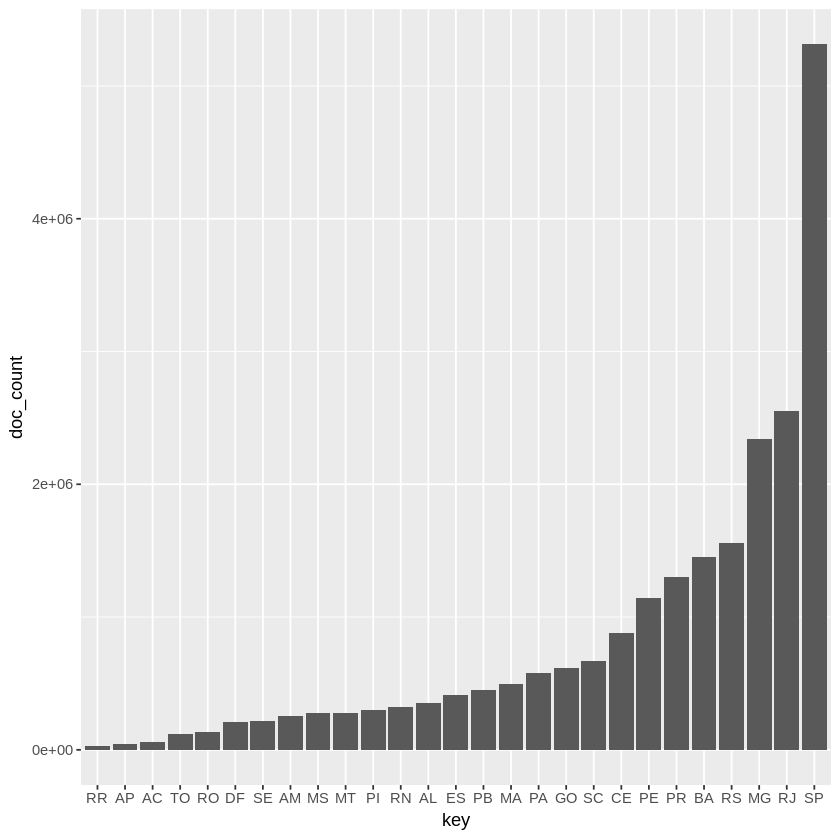

In [16]:
library(ggplot2)
# Basic barplot
ggplot(data = df, aes(x = reorder(key, doc_count), y = doc_count)) +
  geom_bar(stat = "identity") +
  labs(x = "key", y = "doc_count")

Observe também que estamos acessando uma área diferente da busca:

`$aggregations$a1$bucket`

onde `a1` é o nome da agregação que nós especificamos no objeto `agg`. `bucket` é o local onde ficam os resultados da agregação.

### Agregando com filtros

Na busca acima, temos o total de óbitos por estado para todos os anos e todas as doenças, sem filtros. Podemos tornar essa busca mais precisa incluindo um filtro.

In [17]:
elastic::Search(index="datasus-sim-dss", q = "CAUSABAS:I500 AND ano_obito:2016",body = agg, asdf = TRUE)$aggregations$a1$buckets

key,doc_count
SP,3336
MG,1622
RJ,1323
PR,1100
BA,938
RS,766
SC,517
CE,516
GO,504
PE,444


Agora temos o total de óbitos por estado para o CID I500 no ano de 2016. Note que estamos usando o mesmo objeto de agregação `agg`. O filtro é informado através do parâmetro `q`.

Podemos agora fazer a mesma busca, agregando por municípios. Precisamos apenas alterar o objeto `agg` e rodar novamente a busca.

In [18]:
agg <- '{"aggs": {
             "a1": {
               "terms": {
                 "field": "res_codigo_adotado",
                 "size": 6000
               }
             }
         }
        }'

In [19]:
df <- elastic::Search(index="datasus-sim-dss", q = "CAUSABAS:I500 AND ano_obito:2016",body = agg, asdf = TRUE)$aggregations$a1$buckets
str(df)

'data.frame':	3192 obs. of  2 variables:
 $ key      : chr  "355030" "330455" "292740" "230440" ...
 $ doc_count: int  661 456 91 89 86 85 83 82 80 73 ...


### Agregações mais complexas

Essa sintaxe de agregação, apesar de ser facilmente lida, pode ser um pouco complicada para ser escrita devido a quantidade de chaves, aspas e vírgulas necessárias, principalmente em agregações mais complexas. Uma forma interessante de "escrever" agregações maiores é utilizar o Kibana. Crie uma visualização do tipo tabela no Kibana e use todos os filtros e agregações que você quiser. Depois, basta copiar e colar a sintaxe criada pelo Kibana em um objeto no R. 

Criamos uma agregação um pouco mais complexa através do Kibana, tendo resultados por UF e separando por sexo. Veja abaixo onde fica essa sintaxe no kibana:

<img src="img/kibana1.png">
<img src="img/kibana2.png">

Vamos agora usar a sintaxe criada pelo Kibana no R. É recomendável apenas mudar o nome da agregação. O Kibana nomeia as agregações com números e isso causa alguma dificuldade no R. Trocamos os nomes `2` e `3` para `agg1` e `agg2`, respectivamente.

In [20]:
agg <- '{
  "size": 0,
  "_source": {
    "excludes": []
  },
  "aggs": {
    "agg1": {
      "terms": {
        "field": "res_SIGLA_UF",
        "size": 27,
        "order": {
          "_count": "desc"
        }
      },
      "aggs": {
        "agg2": {
          "terms": {
            "field": "def_sexo",
            "size": 5,
            "order": {
              "_count": "desc"
            }
          }
        }
      }
    }
  },
  "stored_fields": [
    "*"
  ],
  "script_fields": {},
  "docvalue_fields": [
    "data_nasc",
    "data_obito"
  ],
  "query": {
    "bool": {
      "must": [
        {
          "match_all": {}
        }
      ],
      "filter": [],
      "should": [],
      "must_not": []
    }
  }
}'

In [21]:
df <- elastic::Search(index="datasus-sim-dss", q = "CAUSABAS:I500 AND ano_obito:2016",body = agg, asdf = TRUE)

Você pode usar o código abaixo para obter uma tabela no mesmo formato do Kibana.

In [22]:
df2 <- cbind(df$aggregations$agg1$buckets$key, data.frame(matrix(unlist(df$aggregations$agg1$buckets$agg2.buckets), ncol=4, byrow=TRUE))[,3:4])
names(df2) <- c("UF", "Feminino", "Masculino")
df2

UF,Feminino,Masculino
SP,1866,1470
MG,812,810
RJ,684,639
PR,596,504
BA,498,440
RS,434,332
SC,302,215
CE,277,239
GO,269,235
PE,228,216


# Fim do tutorial